# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
sns.set_style("whitegrid")
import shap
import xgboost
import optuna
from itertools import product
import statsmodels.api as sm
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.figure_factory as ff


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor , AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeClassifier, RidgeClassifierCV
from sklearn.metrics import mean_squared_error


from imblearn.over_sampling import SMOTENC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier as cb

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model, Model
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers import Adam, SGD

import warnings
warnings.filterwarnings('ignore')

seed = 42

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Read Data

In [2]:
gd = pd.read_csv('/kaggle/input/gold-prices/gold-prices.csv')
gd

,Date,Price
0,1988-05,451.32
1,1988-06,451.66
2,1988-07,437.45
3,1988-10,406.39
4,1988-11,419.97
...,...,...
379,2019-02,1319.76
380,2019-03,1302.29
381,2019-07,1414.61
382,2019-08,1497.10


# Statistics

In [5]:
gd.describe(percentiles=[0.1, 0.25, 0.75, 0.9, 0.95]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,max
Price,384.0,719.497188,461.512046,256.2,291.618,356.825,419.61,1206.605,1347.437,1582.623,1780.65


In [8]:
for col in gd:
    print("Column : ", col)
    print(f"Value counts of {col}: ",gd[col].value_counts().sum())
    print(f"Number of Unique Values in {col}: ",gd[col].nunique())
    print()

Column :  Date
Value counts of Date:  384
Number of Unique Values in Date:  384

Column :  Price
Value counts of Price:  384
Number of Unique Values in Price:  384



In [10]:
gd = gd.set_index("Date")
gd.index = pd.to_datetime(gd.index)
gd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 384 entries, 1988-05-01 to 2019-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   384 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB


# Visualization

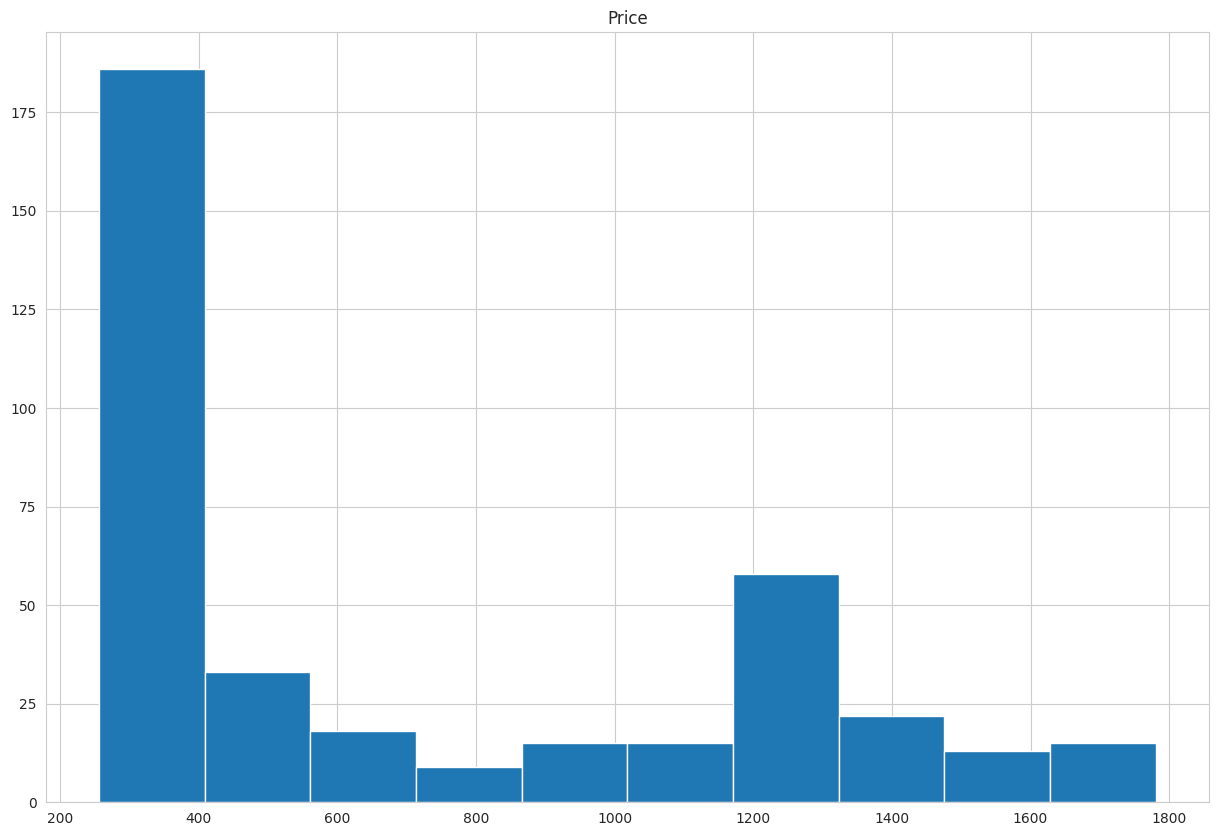

In [23]:
gd.hist(figsize=(15,10))
plt.show()

<Axes: title={'center': 'Gold'}, xlabel='Date'>

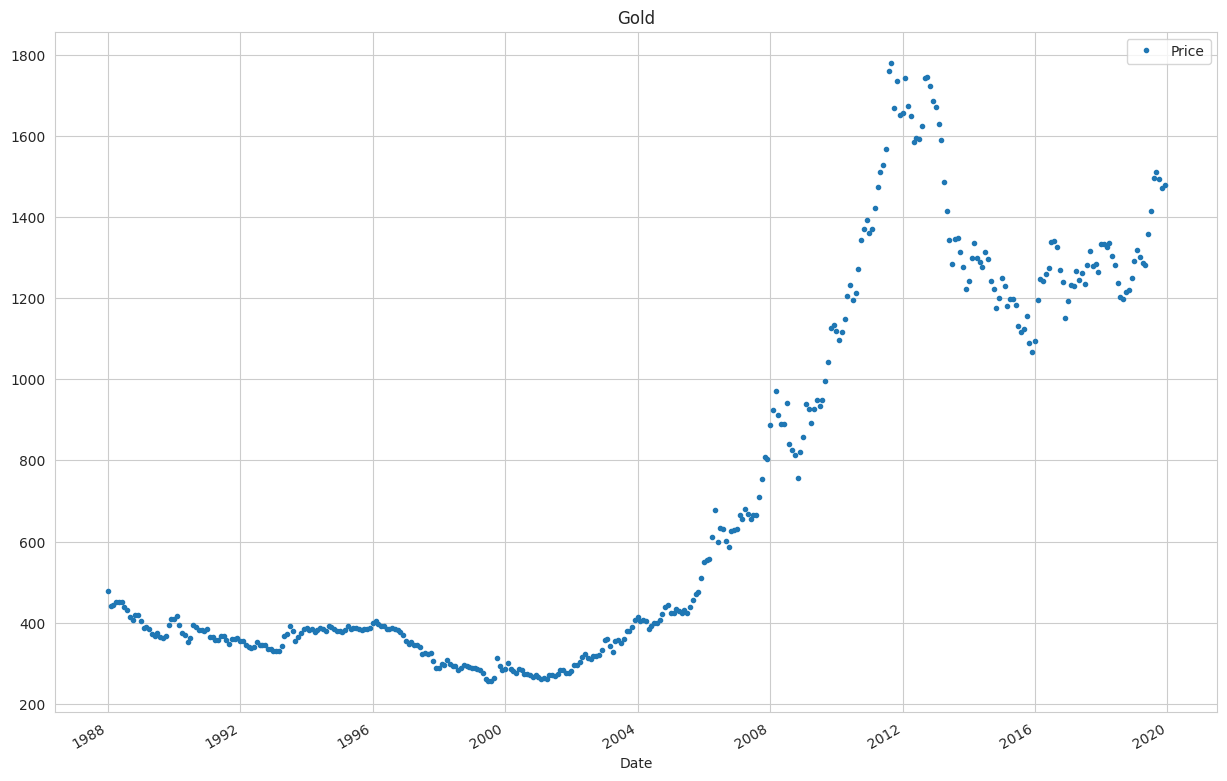

In [24]:
gd.plot(figsize=(15,10),style='.',color=color_pal[0],title='Gold')

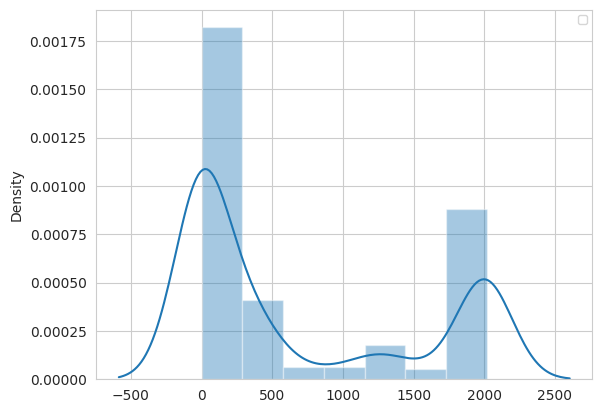

In [138]:
figure = sns.distplot(gd)
figure = figure.legend(loc='best', fontsize=8)

In [27]:
gd["year"] = gd.index.year
gd["month"] = gd.index.month
gd["quarter"] = gd.index.quarter
gd

,Price,month,quarter,year
Date,,,,
1988-05-01,451.32,5,2,1988
1988-06-01,451.66,6,2,1988
1988-07-01,437.45,7,3,1988
1988-10-01,406.39,10,4,1988
1988-11-01,419.97,11,4,1988
...,...,...,...,...
2019-02-01,1319.76,2,1,2019
2019-03-01,1302.29,3,1,2019
2019-07-01,1414.61,7,3,2019


[Text(0.5, 1.0, 'A Heat map to show relationship between variables')]

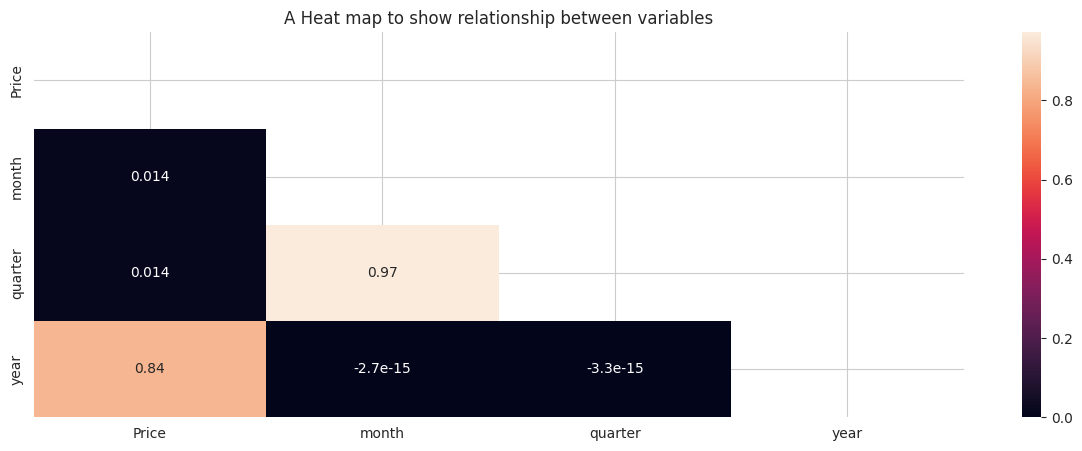

In [31]:
plt.figure(figsize=(15,5))
sns.heatmap(gd.corr(),annot=True,mask=np.triu(np.ones_like(gd.corr()))).set(title='A Heat map to show relationship between variables')

# ML

In [41]:
x = gd.drop("Price", axis=1)
y = gd['Price']

In [42]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=seed)

print("Training Data Shape : ", xtrain.shape, ytrain.shape)
print("Test Data Shape : ", xtest.shape, ytest.shape)

Training Data Shape :  (307, 3) (307,)
Test Data Shape :  (77, 3) (77,)


In [64]:
model_params = {
    'linear_regression':{
        'model':LinearRegression(),
        'params':{

        }
    },
    'Decision_Tree':{
        'model':DecisionTreeRegressor(),
        'params':{
            'max_depth':[10,20,50,100],
            'random_state':[0,42]
        }
    },
    'Random_Forest':{
        'model':RandomForestRegressor(),
        'params':{
            'n_estimators':[10,20,50,100,200]
        }
    },
    'Ridge_regression':{
        'model':Ridge(tol=0.1),
        'params':{
             'alpha':[1,10,20,50,100],
            'max_iter':[50,100,200]
        }
    },
    'Lasso_regression':{
        'model':Lasso(tol=0.1),
        'params':{
            'alpha':[1,10,20,50,100],
            'max_iter':[50,100,200]
        }
    },
    'XGBRegressor':{
        'model':XGBRegressor(),
        'params':{
            'n_estimator':[1000],
            'early_stopping_round':[50]
        }
    }
        
        


}

In [65]:
score=[]
best_score = 0
second_best_score = 0
best_model = None        # This is the best model in the end of the grid search cv
second_best_model = None #This is the second best model in the end of the grid search cv
for model_name,m in model_params.items():
    clf = GridSearchCV(m['model'],m['params'],cv=5)
    clf.fit(xtrain,ytrain)

    if best_score<clf.best_score_:
        second_best_score =  best_score
        second_best_model =  best_model
        best_score = clf.best_score_
        best_model = clf.best_estimator_
    elif clf.best_score_>second_best_score:
        second_best_score = clf.best_score_
        second_best_model = clf.best_estimator_

    score.append({
        'model':model_name,
        'score':clf.best_score_,
        'param':clf.best_params_
    })


pd.DataFrame(score)

[10:59:44] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.

[10:59:45] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.

[10:59:45] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.

[10:59:45] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.

[10:59:45] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.

[10:59:45] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.



,model,score,param
0,linear_regression,0.688183,{}
1,Decision_Tree,0.985454,"{'max_depth': 20, 'random_state': 0}"
2,Random_Forest,0.988504,{'n_estimators': 20}
3,Ridge_regression,0.691196,"{'alpha': 100, 'max_iter': 50}"
4,Lasso_regression,0.692628,"{'alpha': 50, 'max_iter': 50}"
5,XGBRegressor,0.993206,"{'early_stopping_round': 50, 'n_estimator': 1000}"


# The Best

In [66]:
best_model.score(xtest,ytest)

0.9956126614547642

In [68]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_round=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimator=1000, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [67]:
second_best_model.score(xtest,ytest)

0.9932825534884044

In [69]:
second_best_model

RandomForestRegressor(n_estimators=20)

In [71]:
models = {
     'XGBRegressor':best_model,
    'RandomForestRegressor':second_best_model
}

result=[]
for model_name,model in models.items():
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest,ypred)
    rmse = mean_squared_error(ytest,ypred,squared = False)

    result.append({
        'Model':model_name,
        'MSE':mse,
        'RMSE':rmse
    })

pd.DataFrame(result)

,Model,MSE,RMSE
0,XGBRegressor,914.567078,30.241810
1,RandomForestRegressor,1400.292082,37.420477


In [82]:
best_model.save_model('Gold Price ML')

In [104]:
train0 = np.array(gd[:int(gd.shape[0]*0.8)])
test0 = np.array(gd[int(gd.shape[0]*0.8):])
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train0)
test = scaler.transform(test0)
def create_dataset(gd):
    x = []
    y = []
    for i in range(50, gd.shape[0]):
        x.append(gd[i-50:i, 0])
        y.append(gd[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

xtrain, ytrain = create_dataset(train)
xtest, ytest = create_dataset(test)
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))

In [121]:
model = Sequential()

model.add(LSTM(units=96, return_sequences=True, input_shape=(xtrain.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 50, 96)            37632     
                                                                 
 dropout_28 (Dropout)        (None, 50, 96)            0         
                                                                 
 lstm_29 (LSTM)              (None, 50, 96)            74112     
                                                                 
 dropout_29 (Dropout)        (None, 50, 96)            0         
                                                                 
 lstm_30 (LSTM)              (None, 50, 96)            74112     
                                                                 
 dropout_30 (Dropout)        (None, 50, 96)            0         
                                                                 
 lstm_31 (LSTM)              (None, 96)               

In [85]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(gd['Price'], order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters          aic
3   (0, 0, 1, 1)  4510.926018
5   (0, 0, 2, 1)  4512.408097
1   (0, 0, 0, 1)  4512.763531
9   (0, 1, 1, 1)  4512.849512
21  (1, 0, 1, 1)  4512.855567
                                      SARIMAX Results                                       
Dep. Variable:                                Price   No. Observations:                  384
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2252.463
Date:                              Tue, 26 Sep 2023   AIC                           4510.926
Time:                                      11:09:55   BIC                           4522.675
Sample:                                           0   HQIC                          4515.592
                                              - 384                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

In [86]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


gd[['Price']]

,Price
Date,
1988-05-01,451.32
1988-06-01,451.66
1988-07-01,437.45
1988-10-01,406.39
1988-11-01,419.97
...,...
2019-02-01,1319.76
2019-03-01,1302.29
2019-07-01,1414.61


In [107]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(xtrain, ytrain, epochs=50, batch_size=32)

Epoch 1/50
9/9 [==============================] - 9s 137ms/step - loss: 0.0871
Epoch 2/50
9/9 [==============================] - 1s 134ms/step - loss: 0.0386
Epoch 3/50
9/9 [==============================] - 1s 133ms/step - loss: 0.0365
Epoch 4/50
9/9 [==============================] - 1s 133ms/step - loss: 0.0381
Epoch 5/50
9/9 [==============================] - 1s 134ms/step - loss: 0.0423
Epoch 6/50
9/9 [==============================] - 1s 133ms/step - loss: 0.0305
Epoch 7/50
9/9 [==============================] - 1s 135ms/step - loss: 0.0332
Epoch 8/50
9/9 [==============================] - 1s 135ms/step - loss: 0.0324
Epoch 9/50
9/9 [==============================] - 1s 139ms/step - loss: 0.0327
Epoch 10/50
9/9 [==============================] - 1s 134ms/step - loss: 0.0250
Epoch 11/50
9/9 [==============================] - 1s 133ms/step - loss: 0.0252
Epoch 12/50
9/9 [==============================] - 1s 134ms/step - loss: 0.0246
Epoch 13/50
9/9 [==============================] 

loss at epoch 1: 0.08711981028318405
loss at epoch 50: 0.013826369307935238


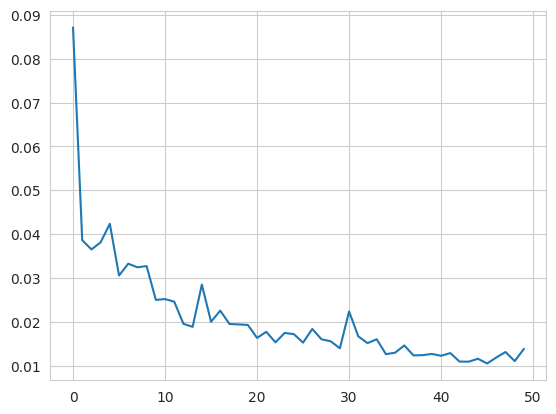

In [108]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 50: {history.history['loss'][49]}")
plt.plot(history.history['loss'])

In [111]:
model = load_model('Gold Prices DL')

In [122]:
train_predict=model.predict(xtrain)
test_predict=model.predict(xtest)

1/1 [==============================] - 0s 63ms/step


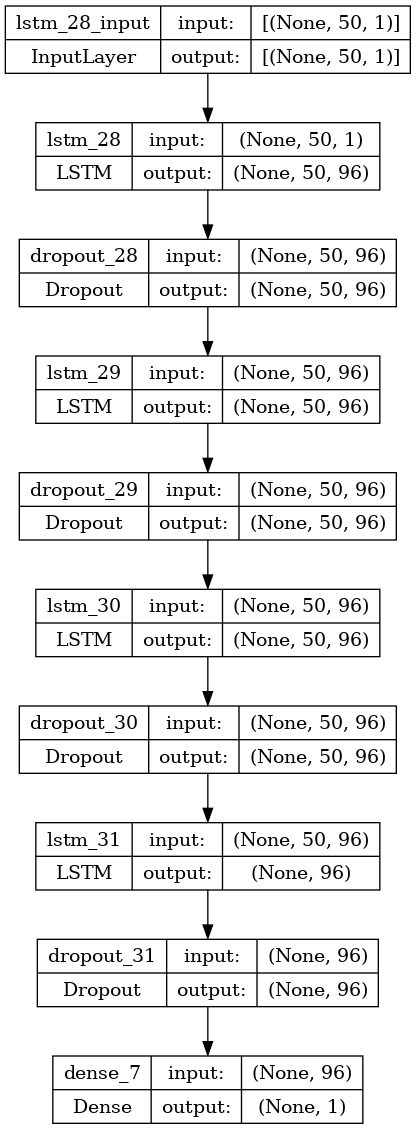

In [131]:
plot_model(model, to_file='Gold Price.png', show_shapes=True, show_layer_names=True)